# Introduction: nonlinear and causal timeseries analysis with Julia

Keep in mind: theoretical background on **delay coordinates embedding** is necessary to **understand** the methodological approach and how to make better decisions regarding the parameters of the algorithms. On the bright side, to understand the code, only rather basic knowledge is necessary. In practice this means that you can learn to use this code base and later return to it to make better decisions!

In [40]:
using CairoMakie
update_theme!(resolution = (500, 300), fontsize = 16)

# DelayEmbeddings.jl

fafafa

# ComplexityMeasures.jl

ComplexityMeasures.jl is a Julia package for computing quantities relevant in timeseries analysis of complex systems. 

# TimeseriesSurrogates.jl

This package is the most complete and most performant software for performing timeseries surrogates hypothesis testing.

### What is a surrogate timeseries?
A surrogate of a timeseries `x` is another timeseries `s` of equal length to `x`. This surrogate `s` is generated from `x` so that it roughly preserves
one or many pre-defined properties of `x`, but is otherwise randomized.

The upper panel in the figure below shows an example of a timeseries and one
surrogate realization that preserves its both power spectrum and its amplitude distribution (histogram). Because of this preservation, the time series look similar.

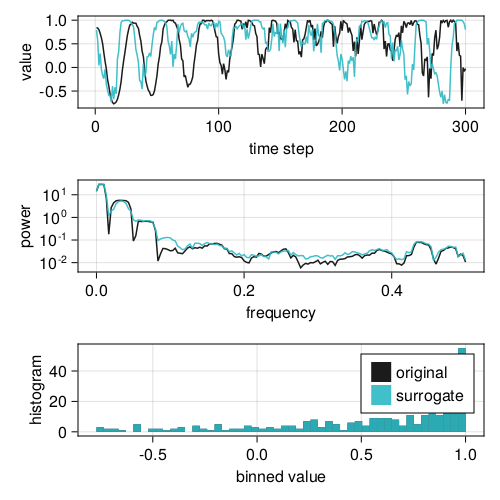

In [43]:
using TimeseriesSurrogates
x = LinRange(0, 20π, 300) .+ 0.05 .* rand(300)
ts = sin.(x./rand(20:30, 300) + cos.(x))
s = surrogate(ts, IAAFT())
surroplot(ts, s)


### Performing surrogate hypothesis tests

A surrogate test is a statistical test of whether a given timeseries satisfies or not a given hypothesis regarding its properties or origin.

For example, the first surrogate methods were created to test the hypothesis,
whether a given timeseries `x` that appears noisy may be the result of a linear
stochastic process or not. If not, it may be a nonlinear process contaminated with observational noise.

To perform such a surrogate test, you need to:

1. Decide what hypothesis to test against
2. Pick a surrogate generating `method` that satisfies the chosen hypothesis
3. Pick a suitable discriminatory statistic `q` with `q(x) ∈ Real`. It must be a statistic that would obtain sufficiently different values for timeseries satisfying, or not, the chosen hypothesis.
4. Compute `q(s)` for thousands of surrogate realizations `s = surrogate(x, method)`
5. Compare `q(x)` with the distribution of `q(s)`. If `q(x)` is significantly outside the e.g., 5-95 confidence interval of the distribution, the hypothesis is rejected.

## Example using TimeseriesSurrogates.jl

For this example we will stick with one of the first usage cases of the methodology: testing whether a timeseries can be interpreted as a linear stochastic process or not.

TimeseriesSurrogates.jl provides 21 different methods for generating surrogates. Each method is fully documented, and in its documentation string explains for what kind of statistical hypothesis it is suitable for. One would have to find the appropriate ones for this hypothesis. For our application, the most basic suitable method is `RandomFourier()` that generates timeseries with same power spectrum as the original one.

In [44]:
using Random: Xoshiro  # for reproducibility
rng = Xoshiro(1234567) # random number generator

using TimeseriesSurrogates
method = RandomFourier()

RandomFourier(true)

Let's see how a timeseries that actually _does follow_ a linear stochastic process looks like, as well as how its surrogate looks like!

In [45]:
n = 400 # timeseries length
x = TimeseriesSurrogates.AR1(; n_steps = n, k = 0.25, rng); # example timeseries

To generate a surrogate you simply call the `surrogate` function

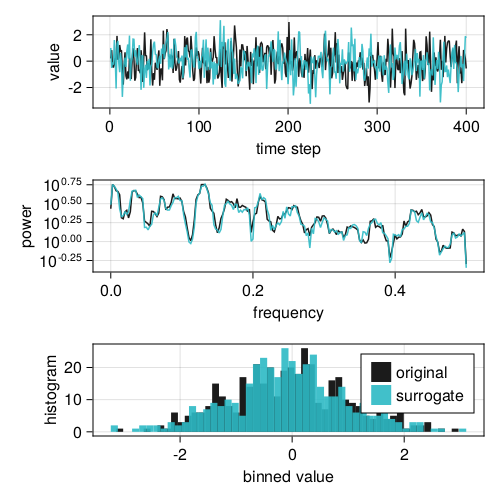

In [46]:
s = surrogate(x, method)
using CairoMakie
surroplot(x, s) # comparison plot of two timeseries

As you can see in the plot, the method `RandomFourier()` approximately preserves the power spectrum of the original timeseries, but not its amplitude distribution.

To perform a surrogate test now we need to choose a discriminatory statistic; in our case this could be something that gives information about temporal correlations such as the self-mutual-information, or something that gives information about structure in state space that a nonlinear system would have, such as the fractal dimension. Since we have already gone through ComplexityMeasures.jl, a simple discriminatory statistic that takes temporal information into accout is the permutation entropy!

Let's perform then the surrogate test; Since we want to apply a process to many surrogate realizations, it is now best to use the `surrogenerator` interface over `surrogate`. We initialize a "surrogate generator"

In [47]:
sgen = surrogenerator(x, method)

Surrogate generator for input timeseries 400-element Vector{Float64} with method:
RandomFourier(true)

and when called as a function with 0 arguments, `sgen` generates a surrogate timeseries of `x`

In [48]:
s = sgen()

400-element Vector{Float64}:
  0.49838621964123747
 -0.504692249943478
 -0.3820285720905731
 -1.6592366704176944
 -2.503097310210255
 -1.7947770083742756
 -0.949805362181326
 -1.2460688922981986
 -1.2911219291606677
 -0.6325972351909478
  ⋮
 -2.0987992411324607
 -2.0752833620114126
 -0.789407923056838
 -1.1255472922074998
  1.5910730302214007
  2.027466936352344
 -0.5110875267162308
 -1.031938746849813
 -2.3081468860739074

Now we're ready to make a histogram of the discriminatory statistic for `x` and many other surrogates

In [49]:
using ComplexityMeasures

m = 3 # order of permutation
N = 10_000 # how many surrogates to use
q = x -> entropy_normalized(SymbolicPermutation(; m), x)
qx = q(x)
qs = map(q, (sgen() for _ in 1:N))

10000-element Vector{Float64}:
 0.9938005740390897
 0.9979790966315247
 0.9943413691301364
 0.9912517565706156
 0.9947553535302747
 0.9978234901540449
 0.9965202950952499
 0.9988256197534224
 0.9942439716424499
 0.9975832578059168
 ⋮
 0.9908014194720753
 0.9982748682963611
 0.9928852298720741
 0.9980073760828894
 0.992121788904039
 0.9966152000146912
 0.9983592137630691
 0.9915276450053773
 0.9959561900020087

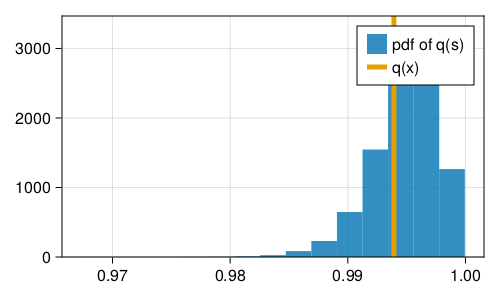

In [50]:
fig, ax = CairoMakie.hist(qs; label = "pdf of q(s)")
vlines!(ax, qx; color = Cycled(2), linewidth = 5, label = "q(x)")
axislegend(ax)
ylims!(ax, 0, nothing)
fig

In [51]:
using Statistics
q01, q99 = quantile(qs, [0.01, 0.99])
q01 ≤ qx ≤ q99 # if false, hypothesis can be rejected!

true

Alright, so far this application was rather simple. But let's perform exactly the same thing but now for a timeseries that is indeed generated by a deterministic nonlinear process contaminated with noise. 

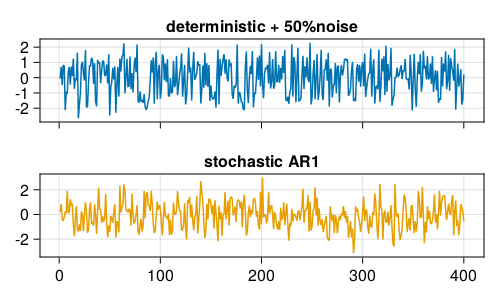

In [52]:
using DynamicalSystemsBase
ds = Systems.logistic(r = 4.0)
y = trajectory(ds, n-1)
# Add 50% observational noise
y = standardize(y) .+ 0.5randn(rng, n)
fig, ax1 = lines(y)
ax2, = lines(fig[2,1], x, color = Cycled(2))
ax1.title = "deterministic + 50%noise"
ax1.xticklabelsvisible = false
ax2.title = "stochastic AR1"
fig

Without labels, it isn't so easy to distinguish stochastic from nonlinear noisy, is it? Let's repeat the same surrogate test.

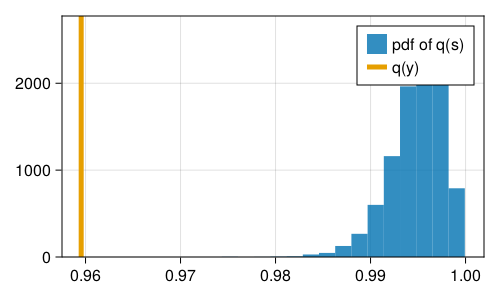

In [53]:
# make distribution of surrogate statistics
sgen = surrogenerator(x, RandomFourier(), rng)
qy = q(y)
qs = map(q, (sgen() for _ in 1:N))
# plot
fig, ax = CairoMakie.hist(qs; label = "pdf of q(s)")
vlines!(ax, qy; color = Cycled(2), linewidth = 5, label = "q(y)")
axislegend(ax)
ylims!(ax, 0, nothing)
fig

In [56]:
q01, q99 = quantile(qs, [0.01, 0.99])
q01 ≤ qy ≤ q99 # if `false`, hypothesis can be rejected!

false

And keep in mind this is even though we have very short timeseries of just 400 points or so, but also that there is a 50% noise added to the first! Timeseries surrogate hypothesis testing is an integral part of any timeseries analysis workflow, whether it is causal, nonlinear, or statistical.

# CausalityTools.jl

There are many many methods to calculate . To keep things simple we focus on one of the most famous ones and time-tested, trasnfer entropy. 

Serious analysis also requires embedding optimization and parameter search.

perfect example would be a case of large transfer entropy across nodes but independence test would make some dissapear.

A system where one coupling is very strong and some others weaker. In this case, the TE across all pairs would be in one pair very large, in the others not so much. But to differentiate from the small TE values which ones are meaningful, you would need to process things further. This is where the independence tests come in.


242-element view(::Matrix{Float64}, :, 1) with eltype Float64:
 -1.238041877147225
 -0.35831503809558285
  1.9779606284563442
  0.48300988190109706
 -0.05672527821377571
  1.5773293253820384
  1.408350777010881
  3.022623711976067
  0.8629315134112687
 -0.055790252503484794
  ⋮
 -0.3477682487626197
 -1.3070270045845547
 -0.7247791956607017
  0.13398475007141997
 -0.9862918917204837
 -0.3214680188091563
 -1.0386677388355565
 -1.5257194300735506
 -1.8240165513164044

# Exercises

## Surrogates of atmospheric reflectance timeseries

Use the following code snippet to download two timeseries from an exercise dataset:

In [60]:
using Downloads, DelimitedFiles
file = Downloads.download("https://raw.githubusercontent.com/JuliaDynamics/NonlinearDynamicsTextbook/master/exercise_data/11.csv")
M = readdlm(file)
x, y = eachcol(M);

utilizing TimeseriesSurrogates.jl and the example code showcased here, show that either of `x, y` cannot be distinguished from a linear stochastic process with a superimposed long term trend. You may use `method = TFTS(0.1)` as the surrogate method, which is suitable for this hypothesis.

_in this exercise you are essentially reproducing the research of section 3.2 of [Datseris & Stevens (2021), Earth's Albedo and Its Symmetry](https://agupubs.onlinelibrary.wiley.com/doi/10.1029/2021AV000440)_